In [112]:
from numpy import pi
from qiskit import Aer, ClassicalRegister, QuantumCircuit, QuantumRegister, transpile
from qiskit.tools.visualization import plot_histogram

In [113]:
class Processor:

    def __init__(self, qc, name, nr_qubits):
        self.qc = qc
        self.name = name
        self.main_reg = QuantumRegister(nr_qubits, f'{name}_main')
        qc.add_register(self.main_reg)
        self.teleport_reg = QuantumRegister(1, f'{name}_teleport')
        qc.add_register(self.teleport_reg)
        self.entanglement_reg = QuantumRegister(1, f'{name}_entanglement')
        qc.add_register(self.entanglement_reg)
        self.measure_reg = ClassicalRegister(2, f'{name}_measure')
        qc.add_register(self.measure_reg)

    def make_entanglement(self, to_processor):
        self.qc.reset(self.entanglement_reg)
        self.qc.reset(to_processor.entanglement_reg)
        self.qc.h(self.entanglement_reg)
        self.qc.cnot(self.entanglement_reg, to_processor.entanglement_reg)

    def teleport_to(self, to_processor):
        self.make_entanglement(to_processor)
        self.qc.cnot(self.teleport_reg, self.entanglement_reg)
        self.qc.h(self.teleport_reg)
        self.qc.measure(self.teleport_reg, self.measure_reg[0])
        self.qc.measure(self.entanglement_reg, self.measure_reg[1])
        self.qc.x(to_processor.entanglement_reg).c_if(self.measure_reg[1], 1)
        self.qc.z(to_processor.entanglement_reg).c_if(self.measure_reg[0], 1)
        self.qc.swap(to_processor.entanglement_reg, to_processor.teleport_reg)

    def distributed_controlled_phase(self, angle, control_qubit_index, target_processor,
                                     target_qubit_index):
        # Teleport local control qubit to remote processor
        self.qc.swap(self.main_reg[control_qubit_index], self.teleport_reg)
        self.teleport_to(target_processor)
        # Perform controlled phase gate on remote processor
        self.qc.cp(angle, target_processor.teleport_reg,
                   target_processor.main_reg[target_qubit_index])
        # Teleport remote control qubit back to local processor
        target_processor.teleport_to(self)
        self.qc.swap(self.teleport_reg, self.main_reg[control_qubit_index])

    def local_hadamard(self, qubit_index):
        self.qc.h(self.main_reg[qubit_index])

    def local_controlled_phase(self, angle, control_qubit_index, target_qubit_index):
        self.qc.cp(angle, self.main_reg[control_qubit_index], self.main_reg[target_qubit_index])

    def final_measure(self):
        self.qc.measure(self.main_reg, self.measure_reg)


In [114]:
class DQFT:

    def __init__(self, n):
        assert n % 2 == 0, "n must be even"
        self.n = n
        self.qc = QuantumCircuit()
        self.alice = Processor(self.qc, 'alice', n // 2)
        self.bob = Processor(self.qc, 'bob', n // 2)
        self.make_dqft()

    def make_dqft(self):
        self.add_qft_rotations(self.n)
        # self.final_measure()

    def add_qft_rotations(self, n):
        if n == 0:
            return
        n -= 1
        self.global_hadamard(n)
        for qubit in range(n):
            self.global_controlled_phase(pi/2**(n-qubit), qubit, n)
        self.add_qft_rotations(n)

    def global_to_local_index(self, global_qubit_index):
        if global_qubit_index < self.n // 2:
            processor = 'alice'
            local_qubit_index = global_qubit_index
        else:
            processor = 'bob'
            local_qubit_index = global_qubit_index - self.n // 2
        return (processor, local_qubit_index)

    def global_hadamard(self, global_qubit_index):
        (processor, local_qubit_index) = self.global_to_local_index(global_qubit_index)
        if processor == 'alice':
            self.alice.local_hadamard(local_qubit_index)
        else:
            self.bob.local_hadamard(local_qubit_index)

    def global_controlled_phase(self, angle, global_control_qubit_index, global_target_qubit_index):
        (control_processor, local_control_qubit_index) = \
            self.global_to_local_index(global_control_qubit_index)
        (target_processor, local_target_qubit_index) = \
            self.global_to_local_index(global_target_qubit_index)
        if control_processor == 'alice':
            if target_processor == 'alice':
                self.alice.local_controlled_phase(angle, local_control_qubit_index,
                                                  local_target_qubit_index)
            else:
                self.alice.distributed_controlled_phase(angle, local_control_qubit_index, self.bob,
                                                        local_target_qubit_index)
        else:
            if target_processor == 'alice':
                self.bob.distributed_controlled_phase(angle, local_control_qubit_index, self.bob,
                                                      local_target_qubit_index)
            else:
                self.bob.local_controlled_phase(angle, local_control_qubit_index,
                                                local_target_qubit_index)

    def final_measure(self):
        self.alice.final_measure()
        self.bob.final_measure()

    def draw(self):
        display(self.qc.draw(fold=False))

    def run(self):
        self.sim = Aer.get_backend('aer_simulator')
        self.qc = transpile(self.qc, self.sim)
        self.result = self.sim.run(self.qc, shots=10000).result()
        self.counts = self.result.get_counts()
        display(plot_histogram(self.counts, title='Counts'))

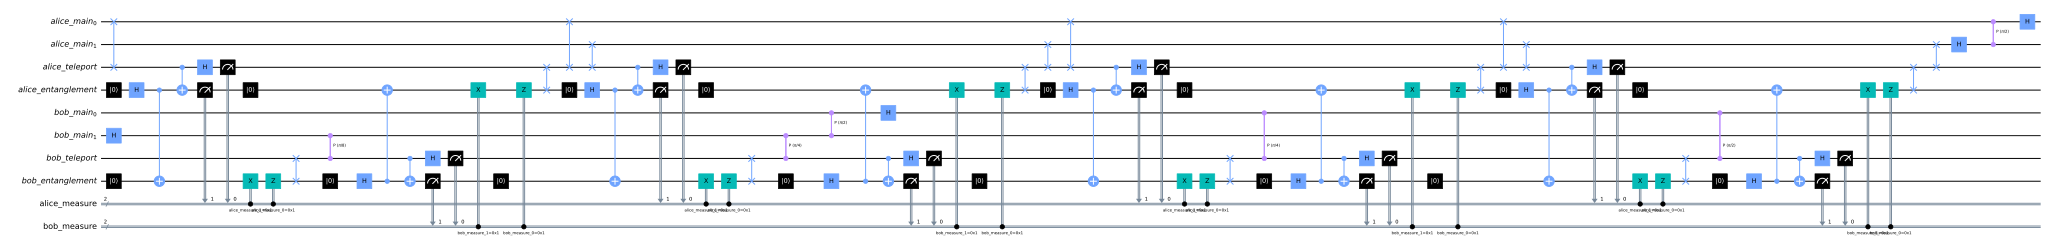

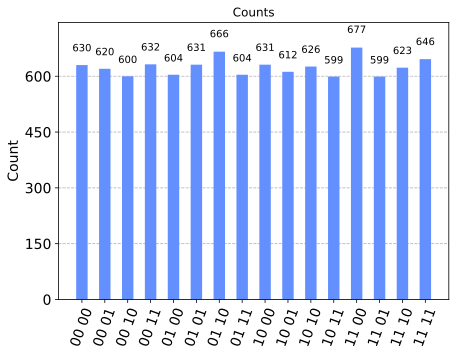

In [115]:
dqft = DQFT(4)
dqft.draw()
dqft.run()